# CQ Notebook

In [1]:
# General (scientific) computing
import os
import time
import glob
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import matplotlib as mpl
from matplotlib.patches import Ellipse
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['image.cmap'] = 'Greys_r'

# Astronomical computing
import fitsio
from astropy.visualization import simple_norm, AsinhStretch
#import astroalign as aa
import sep
import astropy.io.fits as fits
from astropy.wcs import WCS
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy import units as u

# Your Image Calibration and Photometry Code
from complete_process import average_bias, average_dark, average_flat, science_exposure
# Note that you do not need to have magnitude errors implemented. That is for lab 1.5! Returning 0 for all
# magnitude errors is fine for now.
from photometry import create_phot_cat, aper_flux

## Calibrate Images

In [46]:
datadir = './data/'
outputdir = './output/'
caldir = datadir + 'Calibration/'
calibrateddatadir = datadir + 'Calibrated_Data/'
calibrateddatadir = datadir + 'tmp/'

biasfiles = glob.glob(caldir + 'Biases/2022_03_10/*.fit')
darkfiles = glob.glob(caldir + 'Darks/2022_03_10/*.fit')
Rflatfiles = glob.glob(caldir + 'Flats/2022_04_28/*R.fit')
Haflatfiles = glob.glob(caldir + 'Flats/2022_04_28/*Halpha.fit')
CQ_Ha_files = glob.glob(datadir + 'CQ_M94/*Ha*.fit')
CQ_R_files = glob.glob(datadir + 'CQ_M94/*R*.fit')
OS_Ha_files = glob.glob(datadir + 'M94/*Ha*.fit')
OS_R_files = glob.glob(datadir + 'M94/*R*.fit')

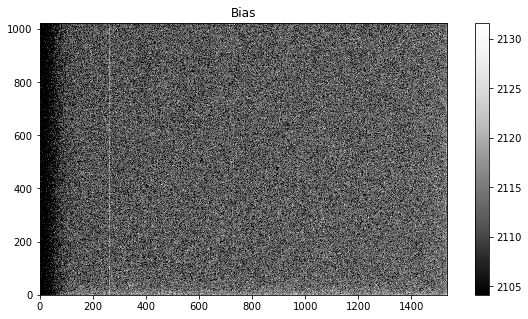

In [79]:
masterbias = average_bias(biasfiles)
plt.imshow(masterbias,vmin=np.median(masterbias)-2*np.std(masterbias),vmax=np.median(masterbias)+5*np.std(masterbias))
plt.colorbar()
plt.title("Bias")
plt.show()

In [4]:
np.std(masterbias)

3.922870286706985

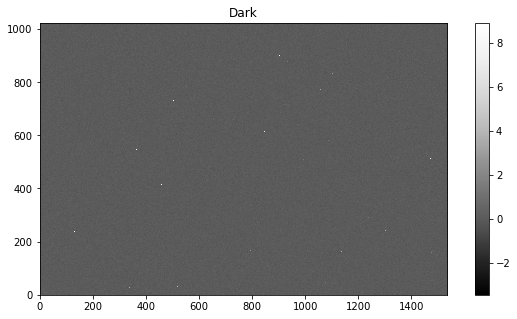

In [80]:
masterdark = average_dark(darkfiles, masterbias)
plt.imshow(masterdark,vmin=np.median(masterdark)-2*np.std(masterdark),vmax=np.median(masterdark)+5*np.std(masterdark))
plt.colorbar()
plt.title("Dark")
plt.show()

In [6]:
np.mean(masterdark)

0.07147382100423175

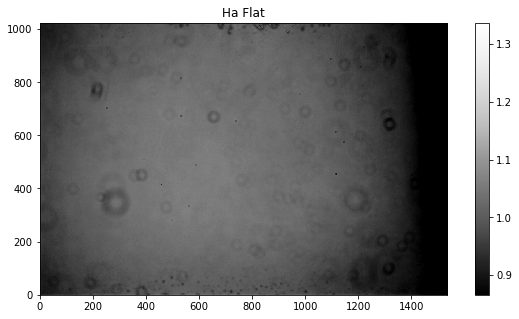

In [83]:
masterHaflat = average_flat(Haflatfiles, masterbias, masterdark)
plt.imshow(masterHaflat,vmin=np.median(masterHaflat)-2*np.std(masterHaflat),vmax=np.median(masterHaflat)+5*np.std(masterHaflat))
plt.colorbar()
plt.title("Ha Flat")
plt.show()

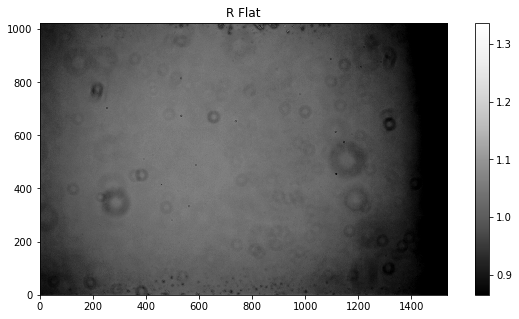

In [84]:
masterRflat = average_flat(Rflatfiles, masterbias, masterdark)
plt.imshow(masterRflat,vmin=np.median(masterRflat)-2*np.std(masterRflat),vmax=np.median(masterRflat)+5*np.std(masterRflat))
plt.colorbar()
plt.title("R Flat")
plt.show()

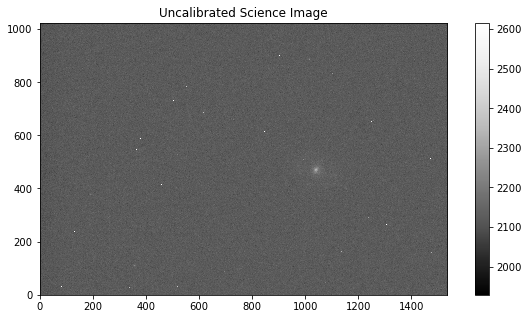

In [86]:
uncalsciim = fitsio.read(CQ_Ha_files[0])
plt.imshow(uncalsciim,vmin=np.median(uncalsciim)-2*np.std(uncalsciim),vmax=np.median(uncalsciim)+5*np.std(uncalsciim))
plt.colorbar()
plt.title("Uncalibrated Science Image")
plt.show()

In [73]:
# WRITE CALIBRATED FILES
for f in CQ_Ha_files:
    name = f[f.rfind('/') +1:]
    im = fitsio.read(f)
    header = fitsio.read_header(f)
    header["BZERO"] = 0
    calim = science_exposure(im, header, masterbias, masterdark, masterHaflat)
    # Removing ', header=header' in the below line fixes the issue of count values going to 30,000ish.
    # Count values are still higher after calibration than before. These issues (or just the first one)
    # might stem from the BSCALE and BZERO parameters in the header, need to check into exactly what
    # those are.
    fitsio.write(calibrateddatadir + 'cal_' + name, calim, clobber=True, header=header)
    #test = fitsio.read(calibrateddatadir + 'cal_' + name)
    #print(test.shape)
    
for f in CQ_R_files:
    name = f[f.rfind('/') +1:]
    im = fitsio.read(f)
    header = fitsio.read_header(f)
    header["BZERO"] = 0
    calim = science_exposure(im, header, masterbias, masterdark, masterHaflat)
    # Removing ', header=header' in the below line fixes the issue of count values going to 30,000ish.
    # Count values are still higher after calibration than before. These issues (or just the first one)
    # might stem from the BSCALE and BZERO parameters in the header, need to check into exactly what
    # those are.
    fitsio.write(calibrateddatadir + 'cal_' + name, calim, clobber=True, header=header)
    #test = fitsio.read(calibrateddatadir + 'cal_' + name)
    #print(test.shape)

In [75]:
# Calibrated CQ Ha files
CQ_Ha_cal_files = glob.glob(calibrateddatadir + "*Ha*")
CQ_R_cal_files = glob.glob(calibrateddatadir + "*R*")

In [65]:
CQ_Ha_cal_files[0]

'./data/tmp/cal_CQ_M94_2022_04_28-008Ha.fit'

In [72]:
im, header = fitsio.read(CQ_Ha_files[0], header=True)
header["BZERO"]

32768.0

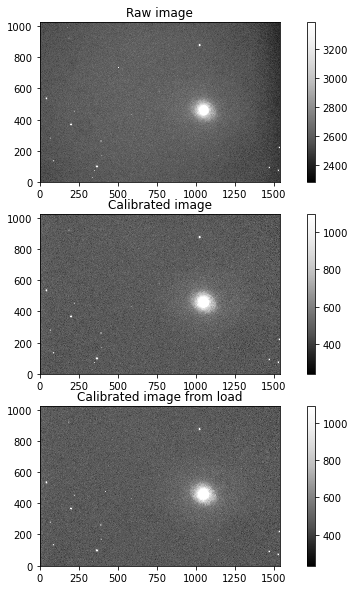

In [120]:
fig, axs = plt.subplots(3, figsize=(10,10))
im, header = fitsio.read(CQ_R_files[0], header=True)
calim = science_exposure(im, header, masterbias, masterdark, masterHaflat)
calim2 = fitsio.read(CQ_R_cal_files[0])
im1 = axs[0].imshow(im, vmin=np.median(im)-2*np.std(im), vmax=np.median(im)+5*np.std(im))
im2 = axs[1].imshow(calim, vmin=np.median(calim)-2*np.std(calim), vmax=np.median(calim)+5*np.std(calim))
im3 = axs[2].imshow(calim2, vmin=np.median(calim2)-2*np.std(calim2), vmax=np.median(calim2)+5*np.std(calim2))
axs[0].set_title("Raw image")
axs[1].set_title("Calibrated image")
axs[2].set_title("Calibrated image from load")
fig.colorbar(im1,ax=axs[0])
fig.colorbar(im2,ax=axs[1])
fig.colorbar(im3,ax=axs[2])
plt.show()

## SNR

In [124]:
uncalsciim, header = fitsio.read(CQ_Ha_files[0], header=True)
calim = science_exposure(uncalsciim, header, masterbias, masterdark, masterHaflat)

fluxHa, _, _ = aper_flux(calim, 1045, 461, source_radius=200, background_width=200, gain=1.2706268068331685, exptime=60)
fluxHa

125629
376996
23430.590065113323


8512.075733586242

In [125]:
uncalsciim, header = fitsio.read(CQ_R_files[0], header=True)
calim = science_exposure(uncalsciim, header, masterbias, masterdark, masterRflat)

fluxR, _, _ = aper_flux(calim, 1045, 461, source_radius=200, background_width=200, gain=1.2706268068331685, exptime=60)
fluxR

125629
376996
1290131.4635439413


319877.55049155396

In [129]:
DW = 13462.1 / 306.75
DW

43.88622656886716

In [148]:
fluxR

319877.55049155396

0.8339373004292755


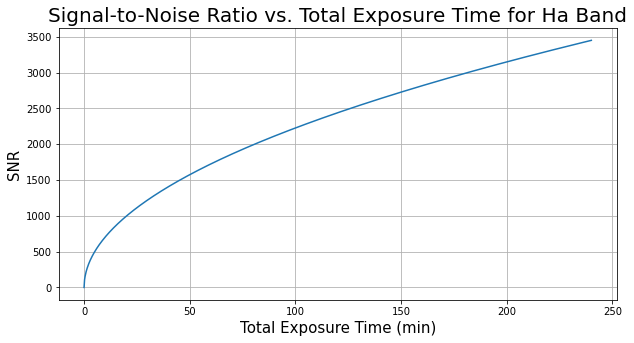

In [146]:
RN = np.std(masterbias)
D = np.mean(masterdark)
n = 125629
#DW = 106.56 / 3
gain = 1.27
sky_Ha = 26838.41
sky_R = 5160525.85
t_Ha = np.linspace(0.0001, 4 * 3600, 1000)
t_R = t_Ha / (DW)
i_Ha = t_Ha / 60
i_R = t_R / 60

'''t_Ha = 3*3600
t_R = t_Ha / DW
i_Ha = t_Ha / 60
i_R = t_R / 15'''

S = (fluxHa * t_Ha) - (fluxR * t_R)
N2 = (fluxHa * t_Ha) + (sky_Ha * t_Ha) + (D * t_Ha * n * gain) + ((RN ** 2) * n * i_Ha * gain) + (sky_R*t_R) + (fluxR * t_R) + (D * t_R * n * gain) + ((RN ** 2) * n * i_R * gain)
N = np.sqrt(N2)

#S = (fluxHa * t_Ha) - (fluxR * t_R / DW)
#N = np.sqrt((fluxHa * t_Ha) + (D * t_Ha * n * i_Ha * gain) + ((RN ** 2) * n * i_Ha * gain) + ((fluxR * t_R + (D * t_R * n * i_R * gain) + ((RN ** 2) * n * i_R * gain)) / (DW ** 2)))


S_Ha = (fluxHa * t_Ha)
S_R = (fluxR * t_R)
N_Ha = np.sqrt((fluxHa * t_Ha) + sky_Ha  * t_Ha + (D * t_Ha * n * gain) + ((RN ** 2) * n * i_Ha * gain))
N_R = np.sqrt((sky_R*t_R + fluxR * t_R + (D * t_R * n * gain) + ((RN ** 2) * n * i_R * gain)))
print(N_Ha[-1]/N_R[-1])

'''print(fluxHa * t_Ha)
print(sky_Ha  * t_Ha)
print((D * t_Ha * n * i_Ha * gain))
print(((RN ** 2) * n * i_Ha * gain))
print(sky_R*t_R)
print(fluxR * t_R)
print((D * t_R * n * i_R * gain))
print((((RN ** 2) * n * i_R * gain)) / (DW ** 2))'''

plt.figure()
plt.rcParams['figure.figsize'] = [10, 5]
#plt.plot((t_Ha + t_R) / 60, S/N)
plt.plot((t_Ha) / 60, S_Ha/N_Ha)
#plt.plot((t_R) / 60, S_R/N_R)
plt.title('Signal-to-Noise Ratio vs. Total Exposure Time for Ha Band', size=20)
plt.xlabel('Total Exposure Time (min)', size=15)
plt.ylabel('SNR', size=15)
#plt.axvline(60, linestyle='--', color='gray')
#plt.axvline(2*60, linestyle='--', color='gray')
#plt.axvline(3*60, linestyle='--', color='gray')
#plt.axvline(4*60, linestyle='--', color='gray')

plt.grid()
plt.show()